# FPE - Breathing trap

In this notebook, we look at another example of a time-dependent potential energy landscape that is slightly more complex than the translating harmonic trap. In this situation, we investigate the dynamics of a diffusing system in the presence of a *breathing* harmonic potential. More succinctly, we investigate a system subjected to the potential energy function

$$ E(x, t) = \frac{k(t)}{2}x^2 $$

In this case, the trap strength is time-dependent, and changes between an initial value $k_0$ at time $t=0$ and $k_{\tau}$ at time $t=\tau$.  So, here the effective Fokker-Planck equation governing the system dynamics is

$$ \partial_t p(x, t) = -\beta Dk(t) \partial_x [x p(x, t)] + D\partial_x^2 p(x, t) $$

In this notebook, we will look at the simulation of this evolution, introducing an explicit time-dependence into the potential (as well as how to implement that in practice) as well as measuring the path-dependence of the work required (as well as the variance of the work) and its dependence on the spacific path. Towards this end, we effectively will confirm the related research finding of Sivak and Crooks in Ref.[1] expressing the optimal minimum-dissipation control protocol ($\dot{k}(t)$) for this system within the linear-response regime.

#### References
- [1] D.A. Sivak & G.E. Crooks, "Thermodynamic metrics and optimal paths", *Phys. Rev. Lett.*, **2012**
- [2] S.J. Large & D.A. Sivak, "Discrete Optimal Control: Minimizing Dissipation in Discretely Driven Nonequilibrium Systems", *J. Stat. Mech.*, **2019**
- [3] D.A. Sivak & G.E. Crooks, "Near-equilibrium measurements of nonequilibrium free energy", *Phys. Rev. Lett.*, **2012**

In [75]:
# First import the relevant modules
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Optional
from pathlib import Path
sns.set(style="darkgrid", palette="hls")

from FPE.Integrator import FPE_Integrator_1D
import FPE.forceFunctions as ff

# Dynamics parameters
D = 1.0
dt = 0.0005
dx = 0.05
x_array = np.arange(-2.5, 2.5, dx)

# and start, initialize an integrator object
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="hard-wall")





Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion



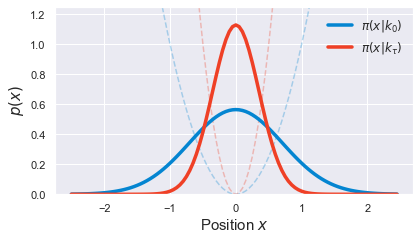

In [18]:
# Initialize the system in its equilibrium distribution
k_init = 2.0
k_final = 8.0
init_var = 1 / k_init
final_var = 1/  k_final

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(fpe.xArray, 0.5 * k_init * (fpe.xArray ** 2), '--', color=sns.xkcd_rgb["cerulean"], alpha=0.3)
ax.plot(fpe.xArray, 0.5 * k_final * (fpe.xArray ** 2), '--', color=sns.xkcd_rgb["tomato"], alpha=0.3)

fpe.initializeProbability(0, init_var)
ax.plot(fpe.xArray, fpe.prob.copy(), linewidth=3.5, color=sns.xkcd_rgb['cerulean'], label=r"$\pi(x|k_0)$")

fpe.initializeProbability(0, final_var)
ax.plot(fpe.xArray, fpe.prob.copy(), linewidth=3.5, color=sns.xkcd_rgb["tomato"], label=r"$\pi(x|k_{\tau})$")

ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$p(x)$", fontsize=15)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim(0, 1.25)
plt.tight_layout()


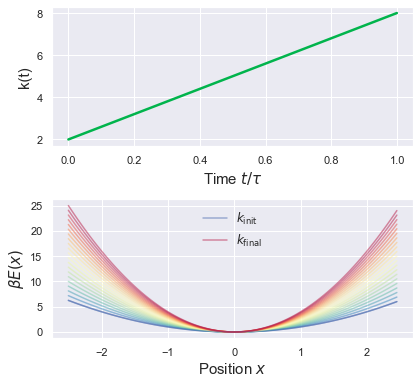

In [29]:
# Now, we can simulate this by looping over a time index, updating the trap
# stiffness paraneter in time

# For a constant control-parameter velocity protocol over a predetermined time
def build_naive_protocol(
    k_init: float, k_final: float, tau: float, dt: float
) -> np.ndarray:
    n_steps = int(tau / dt)
    k_protocol = np.linspace(k_init, k_final, n_steps)
    return k_protocol

fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))
tau = 1
protocol_time = np.arange(0, tau, dt)
protocol = build_naive_protocol(2, 8, tau, dt)
Pal = sns.color_palette("Spectral_r", len(protocol) // 100)

ax[0].plot(protocol_time, protocol, linewidth=2.5, color=sns.xkcd_rgb["shamrock"])

for i, k in enumerate(protocol):
    if i % 100 == 0:
        ax[1].plot(x_array, 0.5 * k * (x_array ** 2), color=Pal[i//100], alpha=0.5)

ax[1].plot(x_array, 0.5 * protocol[0] * (x_array ** 2), color=Pal[0], alpha=0.5, label=r"$k_{\rm init}$")
ax[1].plot(x_array, 0.5 * protocol[-1] * (x_array ** 2), color=Pal[-1], alpha=0.5, label=r"$k_{\rm final}$")

ax[1].legend(fontsize=12, frameon=False)
ax[0].set_xlabel(r"Time $t / \tau$", fontsize=15)
ax[0].set_ylabel(r"k(t)", fontsize=15)

ax[1].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_ylabel(r"$\beta E(x)$", fontsize=15)
plt.tight_layout()

In [41]:
# To simulate the distribution under this protocol, we can just loop over these values
fpe.initializeProbability(0, 1 / k_init)
fpe.initializePhysicalTrackers()
prob_tracker = []
time_tracker = []
work_tracker = []

dk = protocol[1] - protocol[0]

for i, k in enumerate(protocol):
    if i%10 == 0:
        prob_tracker.append(fpe.prob)    
        time_tracker.append(protocol_time[i])
    fpe.work_step(([k, 0]), ([k + dk, 0]), ff.harmonicForce, ff.harmonicEnergy)


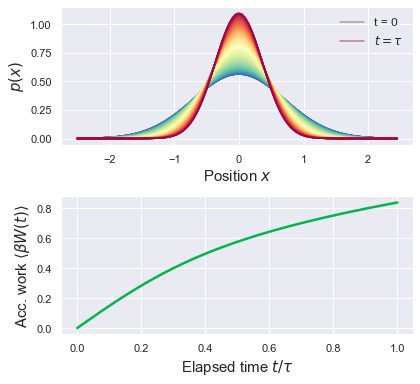

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))
Pal = sns.color_palette("Spectral_r", len(prob_tracker))

ax[0].plot(x_array, prob_tracker[0], color=Pal[0], alpha=0.5, label=r"t = 0")
for i, prob in enumerate(prob_tracker):
    ax[0].plot(x_array, prob, color=Pal[i], alpha=0.5)
ax[0].plot(x_array, prob_tracker[-1], color=Pal[-1], alpha=0.5, label=r"$t = \tau$")
ax[0].legend(fontsize=12, frameon=False)

ax[1].plot(protocol_time, fpe.workTracker, color=sns.xkcd_rgb["shamrock"], linewidth=2.5)

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$p(x)$", fontsize=15)
ax[1].set_xlabel(r"Elapsed time $t / \tau$", fontsize=15)
ax[1].set_ylabel(r"Acc. work $\langle\beta W(t)\rangle$", fontsize=15)

plt.tight_layout()


In [59]:
# We can then look at the total trajectory of accumulated work as a function of
# diffusion coefficient: lower D -> slower relaxation -> higher work done

D_arr = [0.125, 0.25, 0.5, 1, 2]
fpe_arr = [FPE_Integrator_1D(diff, dt, dx, x_array, boundaryCond='hard-wall', output=False) for diff in D_arr]
dk = protocol[1] - protocol[0]

# Now run the same protocol over each diffusion coefficient
res_dict = {}
for diff, fpe in zip(D_arr, fpe_arr):
    res_dict[f"D = {diff}"] = {}
    fpe.initializeProbability(0, 1 / k_init)
    fpe.initializePhysicalTrackers()
    prob_tracker = []
    time_tracker = []
    for i, k in enumerate(protocol):
        if i % 10 == 0:
            prob_tracker.append(fpe.prob)
            time_tracker.append(protocol_time[i])
        fpe.work_step(([k, 0]), ([k + dk, 0]), ff.harmonicForce, ff.harmonicEnergy)
        
    res_dict[f"D = {diff}"]["prob"] = prob_tracker.copy()
    res_dict[f"D = {diff}"]["time"] = time_tracker.copy()
    res_dict[f"D = {diff}"]["work"] = fpe.workTracker.copy()



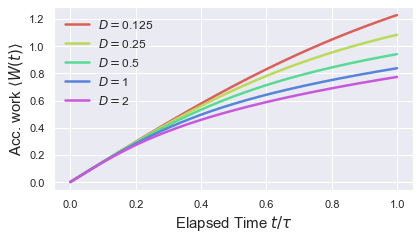

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

Pal = sns.color_palette("hls", len(fpe_arr))

for i, diff in enumerate(D_arr):
    ax.plot(protocol_time, res_dict[f"D = {diff}"]["work"], color=Pal[i], label=r"$D = $" + str(diff), linewidth=2.5)
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Elapsed Time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Acc. work $\langle W(t)\rangle$", fontsize=15)    
plt.tight_layout()

Furthermore, in a timescale-separated limit, when the system does not respond at all to the changes to the potential, this is effectively (from the standpoint of work done) a scenario where the control variable is discretely changing (*i.e.* the initial distribution will not respond to the changing control protocol). If we assume that the accumulation of work will be linear (which is true because the protocol is naive and the forces are linear) then the path of accumulated work will be linear, with final value given by the relative entropy between the two distributions, as was shown in Ref.[4],

$$ \langle \beta W \rangle_{\infty} = D_{\rm KL}\left(p_i || p_f\right) = \int p_i(x) \ln\frac{p_i(x)}{p_f(x)}{\rm d}x $$

While the relative entropy provides an deeper and general understanding of the quantity, in this case we can just calcualte the integral expression directly. Here, the probability distribution is effectively frozen, and so the average work done in this limit corresponds to the integral

$$ \langle \beta W \rangle_{\infty} = \beta\int \left( E_{\rm f}(x) - E_{\rm i}(x)\right) \pi_{\rm i}(x) {\rm d}x $$
$$ = \frac{1}{2}(k_{\rm f} - k_{\rm i})\int x^2 \pi_{\rm i}(x){\rm d}x$$
$$ = \frac{(k_{\rm f} - k_{\rm i})}{2 k_{\rm i}} $$

thus, in our case where $k_{\rm i} = 2$ and $k_{\rm f} = 8$ the result simplifies to

$$ \langle \beta W \rangle_{\infty} = \frac{3}{2} $$


In [69]:

# First we can calculate this numerically, as we would like to be able to do so
# andyways in waht follows
def get_rel_ent(p1: np.ndarray, p2: np.ndarray, dx: float) -> float:
    integrand = p1 * np.log( p1 / p2 )
    return np.sum(integrand * dx)

p1 = np.exp(-0.5 * k_init * x_array)
p2 = np.exp(-0.5 * k_final * x_array)
p1 /= np.sum(p1 * dx)
p2 /= np.sum(p2 * dx)

RE = get_rel_ent(p1, p2, dx)
RE

1.517774589666797

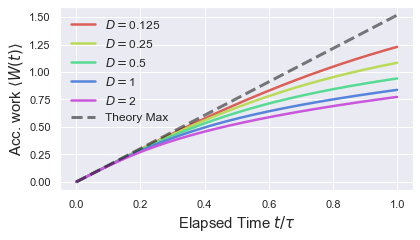

In [70]:
# And therefore, we can add this line to the previous plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

for i, diff in enumerate(D_arr):
    ax.plot(protocol_time, res_dict[f"D = {diff}"]["work"], color=Pal[i], label=r"$D = $" + str(diff), linewidth=2.5)

# Theoretical max line
ax.plot([0, 1], [0, RE], '--', color='k', linewidth=3.0, alpha=0.5, label=r"Theory Max")

ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Elapsed Time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Acc. work $\langle W(t)\rangle$", fontsize=15)    
plt.tight_layout()

So, from this analysis, the theoretical maximum line looks to fall in line with the general trend of the accumualted work with decreasing diffusion coefficients. Next, we turn our focus to quantifying the final work as a function of diffusion coefficient. Here, the work is bound to be above zero, and below the inifinte-time result. In fact, we can also quantify a lower bound by noting that the work can generally be written as a sum over *excess* work and the change in equilibrium free energy

$$ \langle \beta W\rangle \equiv \langle \beta W_{\rm ex}\rangle + \beta \Delta F$$

and thus, in the limit of quasistatic evolution (where the diffusion coefficient $D\to\infty$) the excess work is zero and $\langle \beta W\rangle_{\rm quasi} = \beta\Delta F$. In general, we can evaluate the free energy through the expression (which follows from the definition of the Boltzmann distribution)

$$ \Delta F \equiv \ln\frac{Z_{\rm f}}{Z_{\rm i}}$$

for the partition function $Z$.  In this scenario, the partition function is

$$ Z = \int e^{-\frac{\beta k}{2}x^2} {\rm d} x = \sqrt{2\pi}{\beta k}$$

and thus the free energy difference between the initial and final equilibrium states is

$$ \beta\Delta F = \ln\frac{Z_{\rm f}}{Z_{\rm i}} = \frac{1}{2}\ln\frac{k_{\rm f}}{k_{\rm i}} $$

So, for $k_{\rm i} = 2$ adn $k_{\rm f} = 8$, the free energy difference between initial and final states is

$$\beta\Delta F = \frac{1}{2}\ln 4 \approx 0.693\dots $$

With this we can make one more version of the plot above, now with a lower bound on the work done at time $t$ (indicated by a black circle)


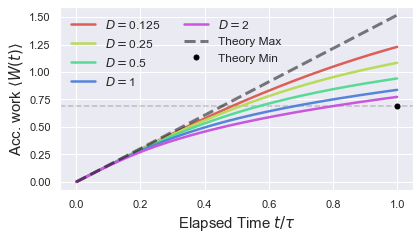

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.axhline(0.5 * np.log(4), linestyle='--', color='k', linewidth=1.5, alpha=0.2)
for i, diff in enumerate(D_arr):
    ax.plot(protocol_time, res_dict[f"D = {diff}"]["work"], color=Pal[i], label=r"$D = $" + str(diff), linewidth=2.5)

# Theoretical max line
ax.plot([0, 1], [0, RE], '--', color='k', linewidth=3.0, alpha=0.5, label=r"Theory Max")
# Theoretical min point
ax.plot([1], [0.5 * np.log(4)], 'o', markersize=5, color='k', label=r"Theory Min")


ax.legend(fontsize=12, frameon=False, ncol=2)
ax.set_xlabel(r"Elapsed Time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Acc. work $\langle W(t)\rangle$", fontsize=15)    
plt.tight_layout()

In [76]:

# NEXT --> Finer grading of diffusion coefficient -> final work as a function of D (or characteristic timescale of system)
# then --> Distance from equilibrium as a function of time along protocol (from NEW free energy)
# Then --> Minimum dissipation protocols: time dependent speed, start scaffolding / idea of simulator class